<a href="https://colab.research.google.com/github/dwesselink/NMA-22-DL-Saltenas-Project/blob/main/Saltenas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install dependencies
!pip install git+https://github.com/NeuromatchAcademy/evaltools --quiet
!pip install pandas --quiet
!pip install seaborn --quiet
from evaltools.airtable import AirtableForm

# Imports
import random

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp

import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from IPython.display import display
from torch.utils.data import DataLoader, TensorDataset

# Imports
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

# Figure settings
import ipywidgets as widgets       # Interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")


In [3]:
# @title Plotting functions

def imshow(img):
  """
  Helper function to plot unnormalised image

  Args:
    img: torch.tensor
      Image to be displayed

  Returns:
    Nothing
  """
  img = img / 2 + 0.5     # Unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.axis(False)
  plt.show()


def plot_function_approximation(x, relu_acts, y_hat):
  """
  Helper function to plot ReLU activations and
  function approximations

  Args:
    x: torch.tensor
      Incoming Data
    relu_acts: torch.tensor
      Computed ReLU activations for each point along the x axis (x)
    y_hat: torch.tensor
      Estimated labels/class predictions
      Weighted sum of ReLU activations for every point along x axis

  Returns:
    Nothing
  """
  fig, axes = plt.subplots(2, 1)

  # Plot ReLU Activations
  axes[0].plot(x, relu_acts.T);
  axes[0].set(xlabel='x',
              ylabel='Activation',
              title='ReLU Activations - Basis Functions')
  labels = [f"ReLU {i + 1}" for i in range(relu_acts.shape[0])]
  axes[0].legend(labels, ncol = 2)

  # Plot Function Approximation
  axes[1].plot(x, torch.sin(x), label='truth')
  axes[1].plot(x, y_hat, label='estimated')
  axes[1].legend()
  axes[1].set(xlabel='x',
              ylabel='y(x)',
              title='Function Approximation')

  plt.tight_layout()
  plt.show()

In [4]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [5]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.
# NOTE: This is mostly a GPU free tutorial.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [6]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu


In [18]:
#Data retrieval
import os, requests

fname = "allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
url = "https://ndownloader.figshare.com/files/28470255"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

filename = "allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
data = pd.read_parquet(filename)

In [7]:
type(data.cre_line)



pandas.core.series.Series

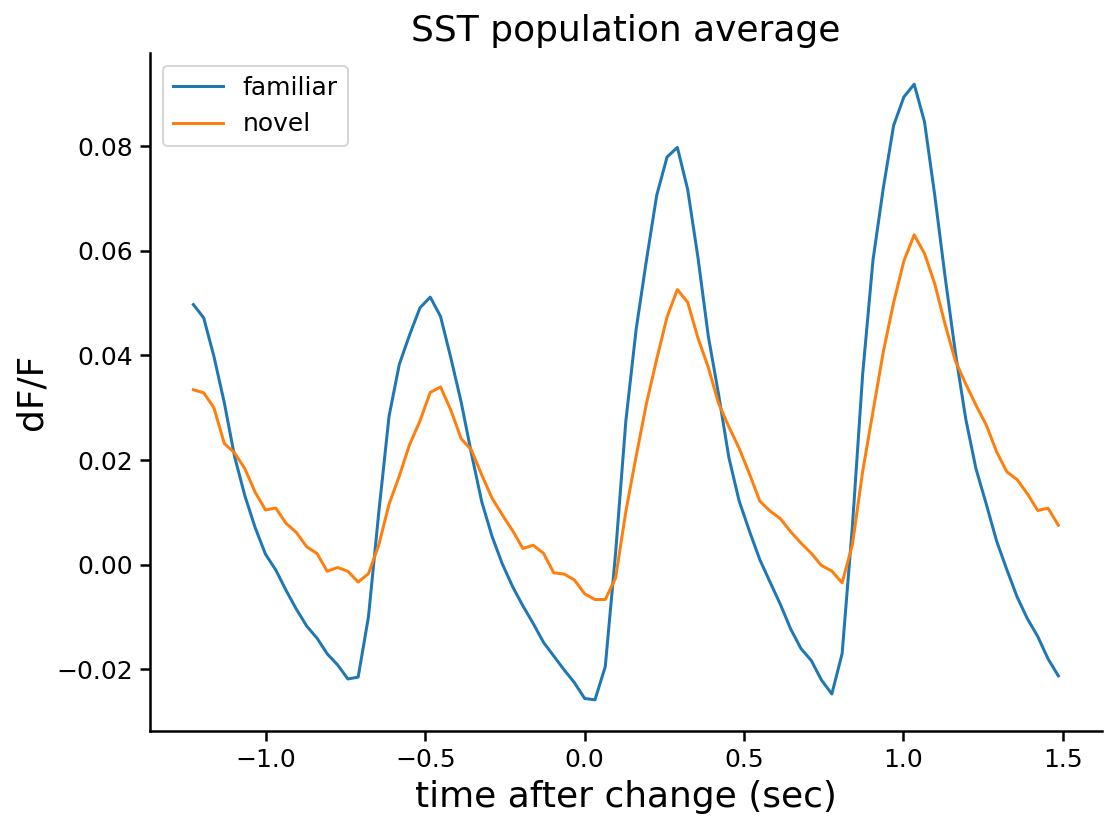

In [19]:
sst_data = data[(data.cre_line == 'Sst-IRES-Cre')&(data.is_change == True)]
vip_data = data[(data.cre_line == 'Vip-IRES-Cre')&(data.is_change == True)]

timestamps = sst_data.trace_timestamps.values[0]
for exposure_level in sst_data.exposure_level.unique():
  traces = sst_data[sst_data.exposure_level==exposure_level].trace.values
  plt.plot(timestamps, np.mean(traces), label=exposure_level)
plt.title('SST population average')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()


In [10]:
def shuffle_and_split_data(X, y, seed):
  """
  Helper function to shuffle and split incoming data

  Args:
    X: torch.tensor
      Input data
    y: torch.tensor
      Corresponding target variables
    seed: int
      Set seed for reproducibility

  Returns:
    X_test: torch.tensor
      Test data [20% of X]
    y_test: torch.tensor
      Labels corresponding to above mentioned test data
    X_train: torch.tensor
      Train data [80% of X]
    y_train: torch.tensor
      Labels corresponding to above mentioned train data
  """
  torch.manual_seed(seed)
  # Number of samples
  N = X.shape[0]
  ####################################################################
  # Fill in missing code below (...),
  # then remove or comment the line below to test your function
  #raise NotImplementedError("Shuffle & split data")
  ####################################################################
  # Shuffle data
  shuffled_indices = torch.randperm(N)   # Get indices to shuffle data, could use torch.randperm
  X = X[shuffled_indices]
  y = y[shuffled_indices]

  # Split data into train/test
  test_size = int(.2 * N)    # Assign test datset size using 20% of samples
  X_test = X[:test_size]
  y_test = y[:test_size]
  X_train = X[test_size:]
  y_train = y[test_size:]

  return X_test, y_test, X_train, y_train


## Uncomment below to test your function
#X_test, y_test, X_train, y_train = shuffle_and_split_data(X, y, seed=SEED)
#plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
#plt.title('Test data')
#plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.14890829694323143


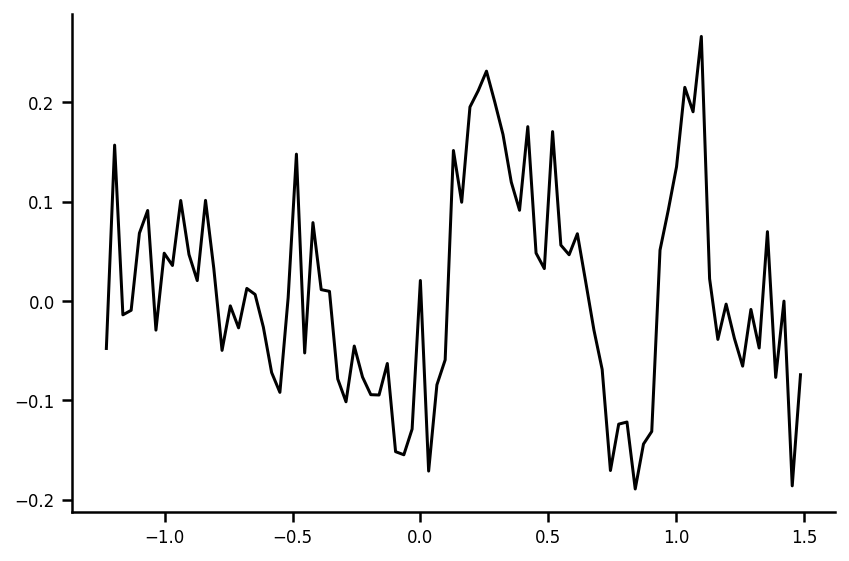

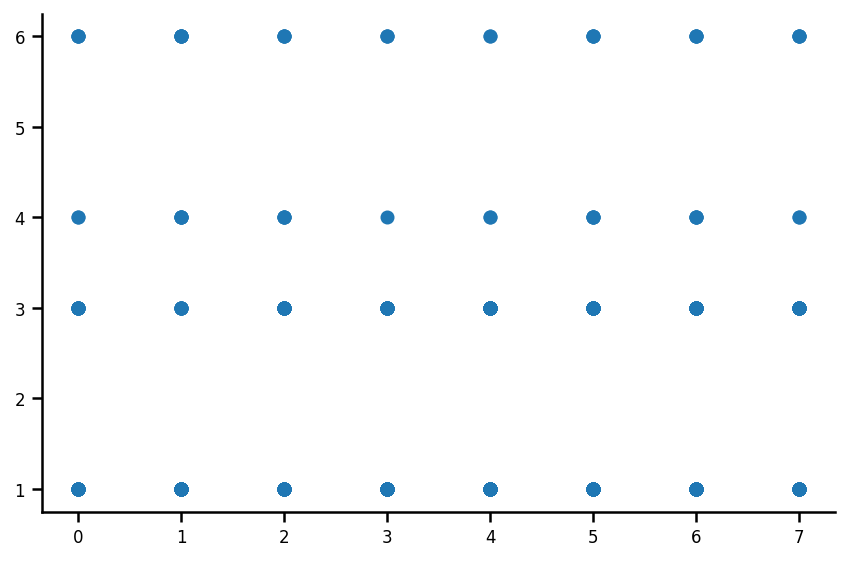

In [11]:
# Our first regression!

vip_data.shape

#select cells in multiple sessions
cells_in_multiple_sessions = []
for cell_specimen_id in vip_data.cell_specimen_id.unique():
  if len(vip_data[vip_data.cell_specimen_id == cell_specimen_id].ophys_session_id.unique()) > 1:
    cells_in_multiple_sessions.append(cell_specimen_id)
#cells_in_multiple_sessions

example_cell_specimen_id = vip_data[vip_data.exposure_level=='novel'].cell_specimen_id.unique()[7]
cell_data = vip_data[vip_data.cell_specimen_id == example_cell_specimen_id]
cell_data = cell_data[(cell_data.image_name == cell_data.image_name.unique()[2])]




# let's pick a cell from a novel image session
example_cell_specimen_id = vip_data[vip_data.exposure_level=='novel'].cell_specimen_id.unique()[7]

cell_data = vip_data[vip_data.cell_specimen_id == example_cell_specimen_id]
cell_data = cell_data[(cell_data.image_name == cell_data.image_name.unique()[2])]

stimulus_presentations_id = cell_data.stimulus_presentations_id.unique()[0]
trial_data = cell_data[cell_data.stimulus_presentations_id == stimulus_presentations_id]
timestamps = trial_data.trace_timestamps.values[0]
trace = trial_data.trace.values[0]

color = [0, 0, 0]
plt.plot(timestamps,trace, color = color)

#average over window
evk_window = np.logical_and(timestamps>0,timestamps<.6)
bkg_window = np.logical_and(timestamps<-.05,timestamps>-.15)

cell_mean = sst_data.apply(lambda x: x.trace[evk_window].mean()-x.trace[bkg_window].mean(),axis=1)

#vip_data.image_index


X_test, y_test, X_train, y_train = shuffle_and_split_data(cell_mean.values, sst_data.image_index.values,seed=SEED)

from sklearn.linear_model import LogisticRegression 
import sklearn.metrics

M = LogisticRegression().fit(X_train.reshape(-1, 1),y_train.reshape(-1, 1))
y_pred = M.predict(X_test.reshape(-1, 1))
score = sklearn.metrics.accuracy_score(y_test.reshape(-1, 1),y_pred)


plt.figure()
plt.subplot()
#plt.plot(y_pred[0:50],marker='s')
#plt.plot(y_test.reshape(-1,1)[0:50],marker='s')
plt.scatter(y_test.reshape(-1,1)[0:300],y_pred[0:300])


#cell_data_array = cell_data.trace.values


#cell_data_array[0][evk_window].mean()-cell_data_array[0][bkg_window].mean()

# writing a comment

print(score)


In [7]:
class Net(nn.Module):
  """
  Initialize MLP Network
  """

  def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num):
    """
    Initialize MLP Network parameters

    Args:
      actv: string
        Activation function
      input_feature_num: int
        Number of input features
      hidden_unit_nums: int
        Number of units in the hidden layer
      output_feature_num: int
        Number of output features

    Returns:
      Nothing
    """
    super(Net, self).__init__()
    self.input_feature_num = input_feature_num # Save the input size for reshaping later
    self.mlp = nn.Sequential() # Initialize layers of MLP

    in_num = input_feature_num # Initialize the temporary input feature to each layer
    for i in range(len(hidden_unit_nums)): # Loop over layers and create each one
      out_num = hidden_unit_nums[i] # Assign the current layer hidden unit from list
      layer = nn.Linear(in_num,out_num) # Use nn.Linear to define the layer
      in_num = out_num # Assign next layer input using current layer output
      self.mlp.add_module('Linear_%d'%i, layer) # Append layer to the model with a name

      actv_layer = eval('nn.%s'%actv) # Assign activation function (eval allows us to instantiate object from string)
      self.mlp.add_module('Activation_%d'%i, actv_layer) # Append activation to the model with a name

    out_layer = nn.Linear(in_num, output_feature_num) # Create final layer
    self.mlp.add_module('Output_Linear', out_layer) # Append the final layer

  def forward(self, x):
    """
    Simulate forward pass of MLP Network

    Args:
      x: torch.tensor
        Input data

    Returns:
      logits: Instance of MLP
        Forward pass of MLP
    """
    # Reshape inputs to (batch_size, input_feature_num)
    # Just in case the input vector is not 2D, like an image!
    x = x.view(-1, self.input_feature_num)

    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    #raise NotImplementedError("Run MLP model")
    ####################################################################

    logits = self.mlp(x) # Forward pass of MLP
    return logits


#input = torch.zeros((100, 2))
## Uncomment below to create network and test it on input
#net = Net(actv='LeakyReLU(0.1)', input_feature_num=2, hidden_unit_nums=[100, 10, 5], output_feature_num=1).to(DEVICE)
#y = net(input.to(DEVICE))
#print(f'The output shape is {y.shape} for an input of shape {input.shape}')

In [13]:
#Data selection and prep


if 'cell_mean' not in vip_data.columns:
  vip_data['cell_mean'] = vip_data.apply(lambda x: x.trace[evk_window].mean()-x.trace[bkg_window].mean(),axis=1)

data_input_full = torch.zeros(len(vip_data.image_index.unique()),len(vip_data.cell_specimen_id.unique()),110)
data_input_n = torch.zeros(len(vip_data.image_index.unique()),len(vip_data.cell_specimen_id.unique()))
for i, I in enumerate(vip_data.image_index.unique()):
  for c, C in enumerate(vip_data.cell_specimen_id.unique()):
    tempset = vip_data[np.logical_and(vip_data.image_index==I,vip_data.cell_specimen_id==C)]
    data_input_n[i,c] = len(tempset.cell_mean)
    
    #print(data_input_n[i,c])
    data_input_full[i,c,:(int(data_input_n[i,c]))] = torch.Tensor(tempset.cell_mean.values)

test_input = data_input_full[:,:,0]

print(test_input.shape)
# print(data_input_full.shape)
# print(torch.max(data_input_n))

def gen_train_samples(N):
  num_images = 8
  train_input = torch.zeros(len(vip_data.image_index.unique())*N,len(vip_data.cell_specimen_id.unique()))
  for n in range(N):   
    batch = torch.zeros(len(vip_data.image_index.unique()),len(vip_data.cell_specimen_id.unique()))
    for i, I in enumerate(vip_data.image_index.unique()):
      for c, C in enumerate(vip_data.cell_specimen_id.unique()):
        batch[i,c] = data_input_full[i,c,np.random.choice(int(data_input_n[i,c])-1,1)+1] 
    train_input[n*num_images:((n+1)*num_images),:] = batch
  train_target = torch.Tensor(np.tile(np.eye(8),(N,1)))    
  return train_input,train_target

train_input, train_target = gen_train_samples(100)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


torch.Size([8, 122])


In [158]:
print(vip_data.columns)
print(vip_data[vip_data.exposure_level=='familiar'].mouse_id.unique())
print(vip_data[vip_data.exposure_level=='novel'].mouse_id.unique())

Index(['stimulus_presentations_id', 'cell_specimen_id', 'trace',
       'trace_timestamps', 'mean_response', 'baseline_response', 'image_name',
       'image_index', 'is_change', 'omitted', 'mean_running_speed',
       'mean_pupil_area', 'response_latency', 'rewarded',
       'ophys_experiment_id', 'imaging_depth', 'targeted_structure',
       'cre_line', 'session_type', 'session_number', 'mouse_id',
       'ophys_session_id', 'ophys_container_id', 'behavior_session_id',
       'full_genotype', 'reporter_line', 'driver_line', 'indicator', 'sex',
       'age_in_days', 'exposure_level', 'cell_mean'],
      dtype='object')
['467951' '467953' '489066' '486737' '492395' '467954']
['467953' '489066' '486737' '492395' '467954']


In [29]:
#Gather data -- full timecourse

full_data = vip_data.groupby(['mouse_id','stimulus_presentations_id','cell_specimen_id','image_index'])['trace'].mean().reset_index()
full_data = full_data.pivot(index=['mouse_id','stimulus_presentations_id','image_index'],columns='cell_specimen_id',values='trace')
full_data = full_data.fillna(0)

f1 = full_data.to_numpy()
for row in range(len(f1)):
  for col in range(len(f1[row])):
    if type(f1[row,col]==0)==type(True):
      f1[row,col] = np.zeros(85)
f1 = np.stack(f1.flatten()).reshape(f1.shape[0],f1.shape[1],85)

randsel = np.random.choice(f1.shape[0],int(f1.shape[0]))
train_input = f1[randsel[:int(.9*f1.shape[0])],:,:]
test_input = f1[randsel[int(.9*f1.shape[0]):],:,:]

train_labels = full_data.reset_index().image_index.values[randsel[:int(.9*f1.shape[0])]]
train_labels = np.identity(8)[train_labels,]
test_labels = full_data.reset_index().image_index.values[randsel[int(.9*f1.shape[0]):]]
test_labels = np.identity(8)[test_labels,]




In [15]:
#Gather data version 3 -- mean firing rate in window

if 'cell_mean' not in vip_data.columns:
  vip_data['cell_mean'] = vip_data.apply(lambda x: x.trace[evk_window].mean()-x.trace[bkg_window].mean(),axis=1)

full_data = vip_data.groupby(['mouse_id','stimulus_presentations_id','cell_specimen_id','image_index'])['cell_mean'].mean().reset_index()
full_data = full_data.pivot(index=['mouse_id','stimulus_presentations_id','image_index'],columns='cell_specimen_id',values='cell_mean')

f1 = full_data.values
randsel = np.random.choice(f1.shape[0],int(f1.shape[0]))

train_input = f1[randsel[:int(.9*f1.shape[0])],]
train_input[np.isnan(train_input)] = 0
test_input = f1[randsel[int(.9*f1.shape[0]):],]
test_input[np.isnan(test_input)] = 0

train_labels = full_data.reset_index().image_index.values[randsel[:int(.9*f1.shape[0])]]
train_labels = np.identity(8)[train_labels,]
test_labels = full_data.reset_index().image_index.values[randsel[int(.9*f1.shape[0]):]]
test_labels = np.identity(8)[test_labels,]


full_data['mouse_index'] = full_data.groupby('mouse_id', sort=False).ngroup()
mouse_index = np.identity(np.max(full_data.mouse_index.values)+1)[full_data.mouse_index.values]
train_mouse_index = mouse_index[randsel[:int(.9*f1.shape[0])],]
test_mouse_index = mouse_index[randsel[int(.9*f1.shape[0]):],]

#train_mouse_id = full_data.reset_index().mouse_id.values[randsel[:int(.9*f1.shape[0])]]
#train_mouse_id = np.expand_dims(train_mouse_id,1).astype(float)
#test_mouse_id = full_data.reset_index().mouse_id.values[randsel[int(.9*f1.shape[0]):]]
#test_mouse_id = np.expand_dims(test_mouse_id,1).astype(float)




[3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5]


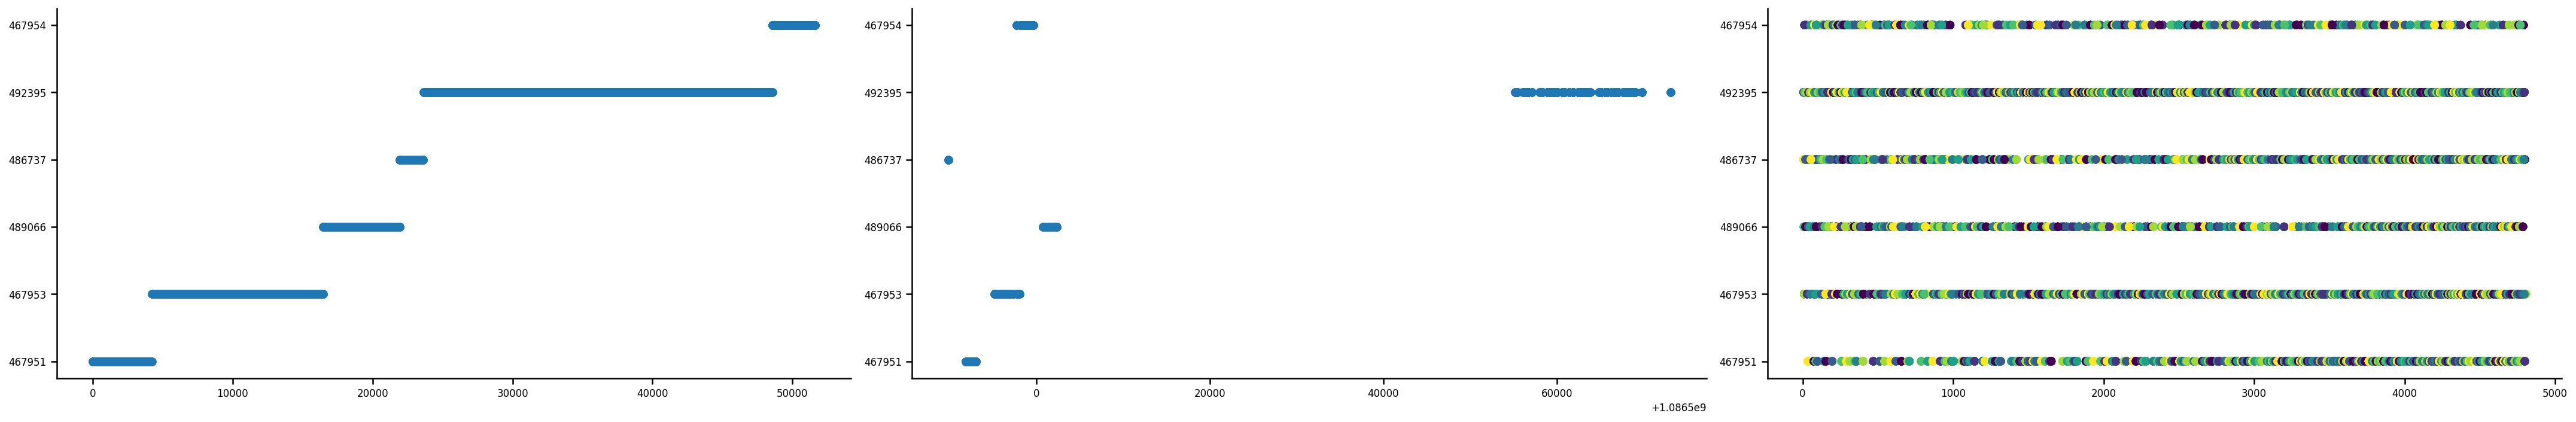

In [ ]:
fig,axes = plt.subplots(1,3,figsize=(30,5))
axes[0].scatter(range(0,len(vip_data.mouse_id)),vip_data.mouse_id)
#print(vip_data.mouse_id.unique())

vip_data_grouped = vip_data.groupby(by=['mouse_id','cell_specimen_id'])

_, cell_mouse = np.unique(vip_data.groupby(by='cell_specimen_id')['mouse_id'].describe()['top'].values,return_inverse='true')

print(cell_mouse)

axes[1].scatter(vip_data.cell_specimen_id,vip_data.mouse_id)

#print(len(vip_data.stimulus_presentations_id.unique()))

axes[2].scatter(vip_data.stimulus_presentations_id,vip_data.mouse_id,c=vip_data.image_index)

  0%|          | 0/2500 [00:00<?, ?it/s]

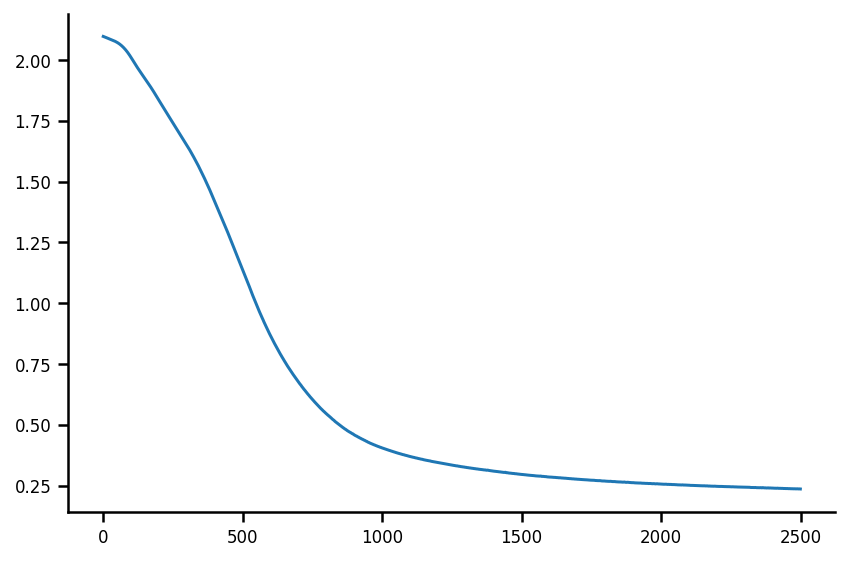

In [16]:
#our first net
net = Net(actv='LeakyReLU(0.1)', input_feature_num=122, hidden_unit_nums=[100, 10, 8], output_feature_num=8).to(DEVICE)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
device = 'cuda'
train_input = torch.Tensor(train_input).to(device)
labels = torch.Tensor(train_labels).to(device)
test_input = torch.Tensor(test_input).to(device)
training_losses = []
N_epochs = 2500

# Train it
net.to(device)
net.train()

for i in tqdm(range(N_epochs)):

  optimizer.zero_grad()
  outputs = net(train_input)
  loss = criterion(outputs,labels)
  loss.backward()
  optimizer.step()
  training_losses += [loss.item()]

net.eval()

plt.plot(training_losses)

  0%|          | 0/2500 [00:00<?, ?it/s]

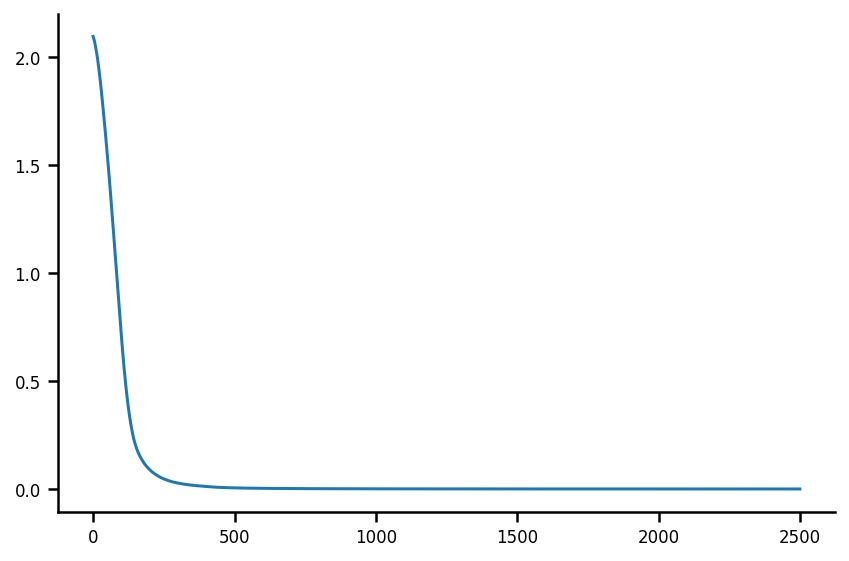

In [30]:
#our first net without Mouse ID, with full time course
net = Net(actv='LeakyReLU(0.1)', input_feature_num=122*85, hidden_unit_nums=[100, 10, 8], output_feature_num=8).to(DEVICE)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
device = 'cuda'
train_input = torch.Tensor(train_input).to(device).permute(0,2,1).reshape(train_input.shape[0],-1)
labels = torch.Tensor(train_labels).to(device)
test_input = torch.Tensor(test_input).to(device).permute(0,2,1).reshape(test_input.shape[0],-1)
training_losses = []
N_epochs = 2500

# Train it
net.to(device)
net.train()

for i in tqdm(range(N_epochs)):

  optimizer.zero_grad()
  outputs = net(train_input)
  loss = criterion(outputs,labels)
  loss.backward()
  optimizer.step()
  training_losses += [loss.item()]

net.eval()



# correct = 0
# total = 0
#     for data in data_loader:
#       inputs, labels = data
#       inputs = inputs.to(device).float()
#       labels = labels.to(device).long()

#       outputs = net(inputs)
#       _, predicted = torch.max(outputs, 1)
#       total += labels.size(0)
#       correct += (predicted == labels).sum().item()

#     acc = 100 * correct / total
#     return total, acc


# def test(data_loader):
#     """
#     Function to gauge network performance

#     Args:
#       data_loader: torch.utils.data type
#         Combines the test dataset and sampler, and provides an iterable over the given dataset.

#     Returns:
#       acc: float
#         Performance of the network
#       total: int
#         Number of datapoints in the dataloader
#     """
#     correct = 0
#     total = 0
#     for data in data_loader:
#       inputs, labels = data
#       inputs = inputs.to(device).float()
#       labels = labels.to(device).long()

#       outputs = net(inputs)
#       _, predicted = torch.max(outputs, 1)
#       total += labels.size(0)
#       correct += (predicted == labels).sum().item()

#     acc = 100 * correct / total
#     return total, acc

#   train_total, train_acc = test(train_loader)
#   test_total, test_acc = test(test_loader)

#   if verbose:
#     print(f'\nAccuracy on the {train_total} training samples: {train_acc:0.2f}')
#     print(f'Accuracy on the {test_total} testing samples: {test_acc:0.2f}\n')

#   if training_plot:
#     plt.plot(training_losses)
#     plt.xlabel('Batch')
#     plt.ylabel('Training loss')
#     plt.show()

#   return train_acc, test_acc

plt.plot(training_losses)

In [43]:
#Load big dataset
import pandas as pd

# from google.colab import drive
# drive.mount('/content/drive')
dir = '/content/drive/MyDrive/'
all_data = pd.read_pickle(dir + 'mice_VIP_N5.pkl')

In [44]:
#Data subsetting
all_data = all_data.query('exposure_level=="familiar"')
all_data = all_data.query('image_name!="omitted"')
all_data = all_data.query('is_change==False')

#all_data = all_data.groupby(['mouse_id','stimulus_presentations_id','cell_specimen_id','image_name'])['dff_bc'].mean().reset_index()
all_data2 = all_data.pivot(index=['mouse_id','stimulus_presentations_id','ophys_session_id','image_name'],columns='cell_specimen_id',values='dff_bc')
all_data = all_data2.fillna(0)
del all_data2


In [45]:
import numpy as np

f1 = all_data.to_numpy()
randsel = np.random.choice(f1.shape[0],int(f1.shape[0]))
train_input = f1[randsel[:int(.9*f1.shape[0])],:]
test_input = f1[randsel[int(.9*f1.shape[0]):],:]

unique_label_name, train_labels = np.unique(all_data.reset_index().image_name.values,return_inverse='true')
train_labels = np.identity(unique_label_name.shape[0])[train_labels[randsel[:int(.9*f1.shape[0])]],]
_, test_labels = np.unique(all_data.reset_index().image_name.values,return_inverse='true')
test_labels = np.identity(unique_label_name.shape[0])[test_labels[randsel[int(.9*f1.shape[0]):]],]


In [31]:
class Net(nn.Module):
  """
  Initialize MLP Network
  """

  def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num,dropout=False):
    """
    Initialize MLP Network parameters

    Args:
      actv: string
        Activation function
      input_feature_num: int
        Number of input features
      hidden_unit_nums: int
        Number of units in the hidden layer
      output_feature_num: int
        Number of output features

    Returns:
      Nothing
    """
    super(Net, self).__init__()
    self.input_feature_num = input_feature_num # Save the input size for reshaping later
    self.mlp = nn.Sequential() # Initialize layers of MLP

    in_num = input_feature_num # Initialize the temporary input feature to each layer
    for i in range(len(hidden_unit_nums)): # Loop over layers and create each one
      
      
      out_num = hidden_unit_nums[i] # Assign the current layer hidden unit from list
      layer = nn.Linear(in_num,out_num) # Use nn.Linear to define the layer
      in_num = out_num # Assign next layer input using current layer output
      self.mlp.add_module('Linear_%d'%i, layer) # Append layer to the model with a name
      if dropout == 1:
        if i == 3:
          self.mlp.add_module('Dropout_%d'%i, nn.Dropout())

      actv_layer = eval('nn.%s'%actv) # Assign activation function (eval allows us to instantiate object from string)
      self.mlp.add_module('Activation_%d'%i, actv_layer) # Append activation to the model with a name

    out_layer = nn.Linear(in_num, output_feature_num) # Create final layer
    self.mlp.add_module('Output_Linear', out_layer) # Append the final layer

  def forward(self, x):
    """
    Simulate forward pass of MLP Network

    Args:
      x: torch.tensor
        Input data

    Returns:
      logits: Instance of MLP
        Forward pass of MLP
    """
    # Reshape inputs to (batch_size, input_feature_num)
    # Just in case the input vector is not 2D, like an image!
    x = x.view(-1, self.input_feature_num)

    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    #raise NotImplementedError("Run MLP model")
    ####################################################################

    logits = self.mlp(x) # Forward pass of MLP
    return logits


#input = torch.zeros((100, 2))
## Uncomment below to create network and test it on input
#net = Net(actv='LeakyReLU(0.1)', input_feature_num=2, hidden_unit_nums=[100, 10, 5], output_feature_num=1).to(DEVICE)
#y = net(input.to(DEVICE))
#print(f'The output shape is {y.shape} for an input of shape {input.shape}')

In [46]:
class NetDropout(nn.Module):
  """
  Network Class - 2D with the following structure:
  nn.Linear(1, 300) + leaky_relu(self.dropout1(self.fc1(x))) # First fully connected layer with 0.4 dropout
  nn.Linear(300, 500) + leaky_relu(self.dropout2(self.fc2(x))) # Second fully connected layer with 0.2 dropout
  nn.Linear(500, 1) # Final fully connected layer
  """

  def __init__(self,input_feature_num):
    """
    Initialize parameters of NetDropout

    Args:
      None

    Returns:
      Nothing
    """
    super(NetDropout, self).__init__()

    self.fc1 = nn.Linear(input_feature_num, 300)
    self.fc2 = nn.Linear(300, 500)
    self.fc3 = nn.Linear(500, 8)
    # We add two dropout layers
    self.dropout1 = nn.Dropout(0.4)
    self.dropout2 = nn.Dropout(0.2)

  def forward(self, x):
    """
    Forward pass of NetDropout

    Args:
      x: torch.tensor
        Input features

    Returns:
      output: torch.tensor
        Output/Predictions
    """
    x = F.leaky_relu(self.dropout1(self.fc1(x)))
    x = F.leaky_relu(self.dropout2(self.fc2(x)))
    output = self.fc3(x)
    return output

  0%|          | 0/5000 [00:00<?, ?it/s]

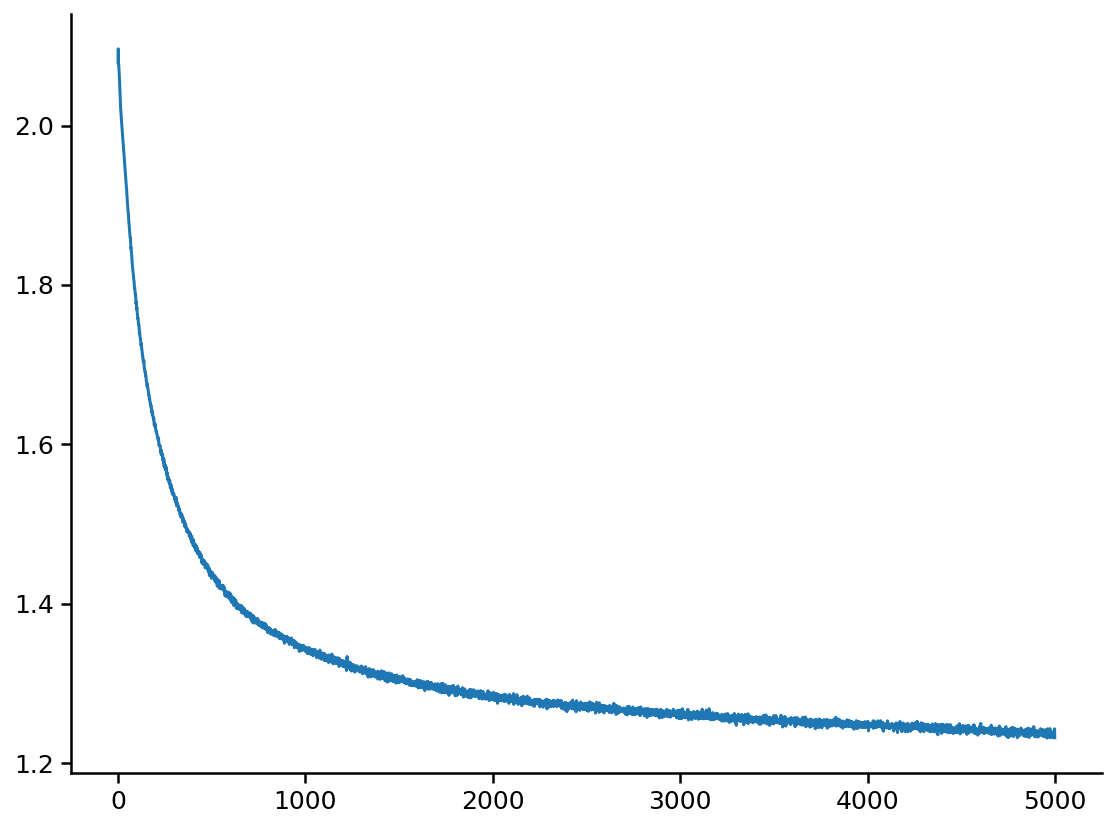

In [49]:
import torch.nn.functional as F

net = NetDropout(train_input.shape[1]).to(DEVICE)
optimizer = optim.Adam(net.parameters(),weight_decay=1e-5, lr=1e-2)
criterion = nn.CrossEntropyLoss()
device = 'cuda'
train_input = torch.Tensor(train_input).to(device)
labels = torch.Tensor(train_labels).to(device)
test_input = torch.Tensor(test_input).to(device)
training_losses = []
N_epochs = 5000

# Train it
net.to(device)
net.train()

for i in tqdm(range(N_epochs)):

  optimizer.zero_grad()
  outputs = net(train_input)
  loss = criterion(outputs,labels)
  loss.backward()
  optimizer.step()

  

  training_losses += [loss.item()]

net.eval()

plt.plot(training_losses)


In [37]:
train_input.shape[1]

145

  0%|          | 0/10000 [00:00<?, ?it/s]

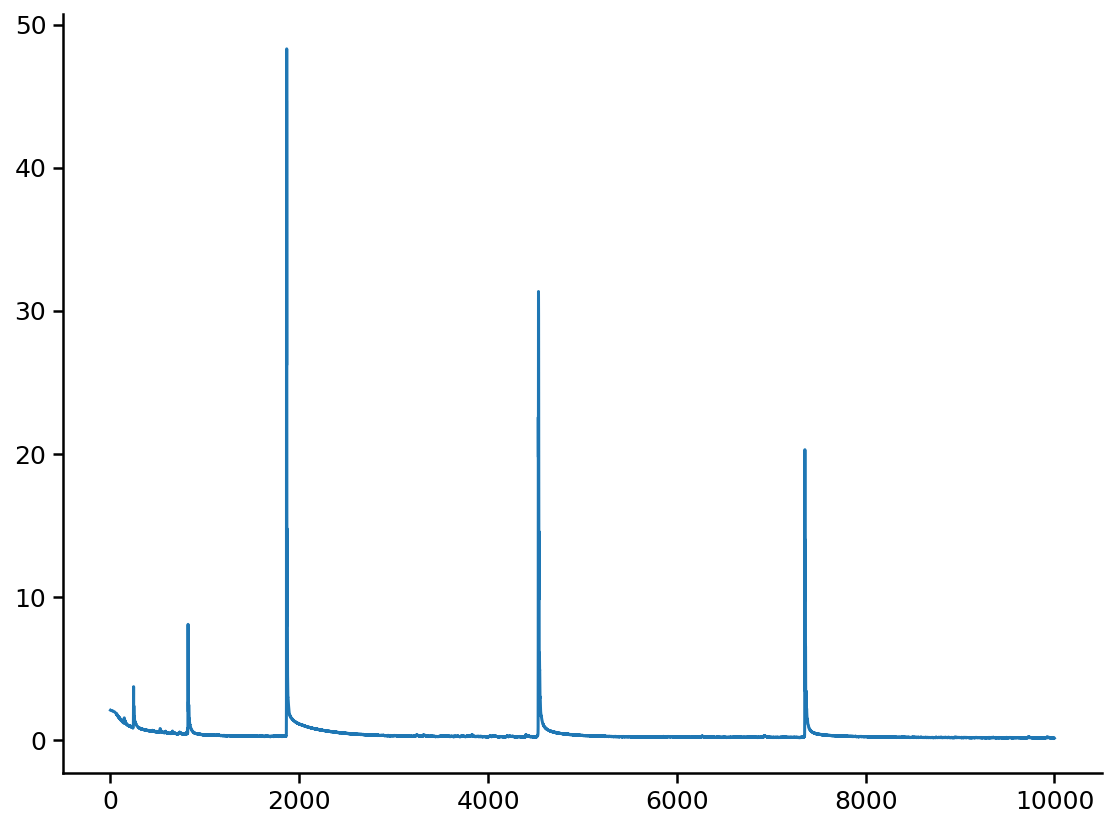

In [32]:
#Basic net with all_data
net = Net(actv='LeakyReLU(0.1)', input_feature_num=train_input.shape[1], hidden_unit_nums=[145, 10, 10, 8], output_feature_num=8,dropout=1).to(DEVICE)
optimizer = optim.Adam(net.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()
device = 'cuda'
train_input = torch.Tensor(train_input).to(device)
labels = torch.Tensor(train_labels).to(device)
test_input = torch.Tensor(test_input).to(device)
training_losses = []
N_epochs = 10000

# Train it
net.to(device)
net.train()

for i in tqdm(range(N_epochs)):

  optimizer.zero_grad()
  outputs = net(train_input)
  loss = criterion(outputs,labels)
  loss.backward()
  optimizer.step()

  

  training_losses += [loss.item()]

net.eval()

plt.plot(training_losses)

  0%|          | 0/5000 [00:00<?, ?it/s]

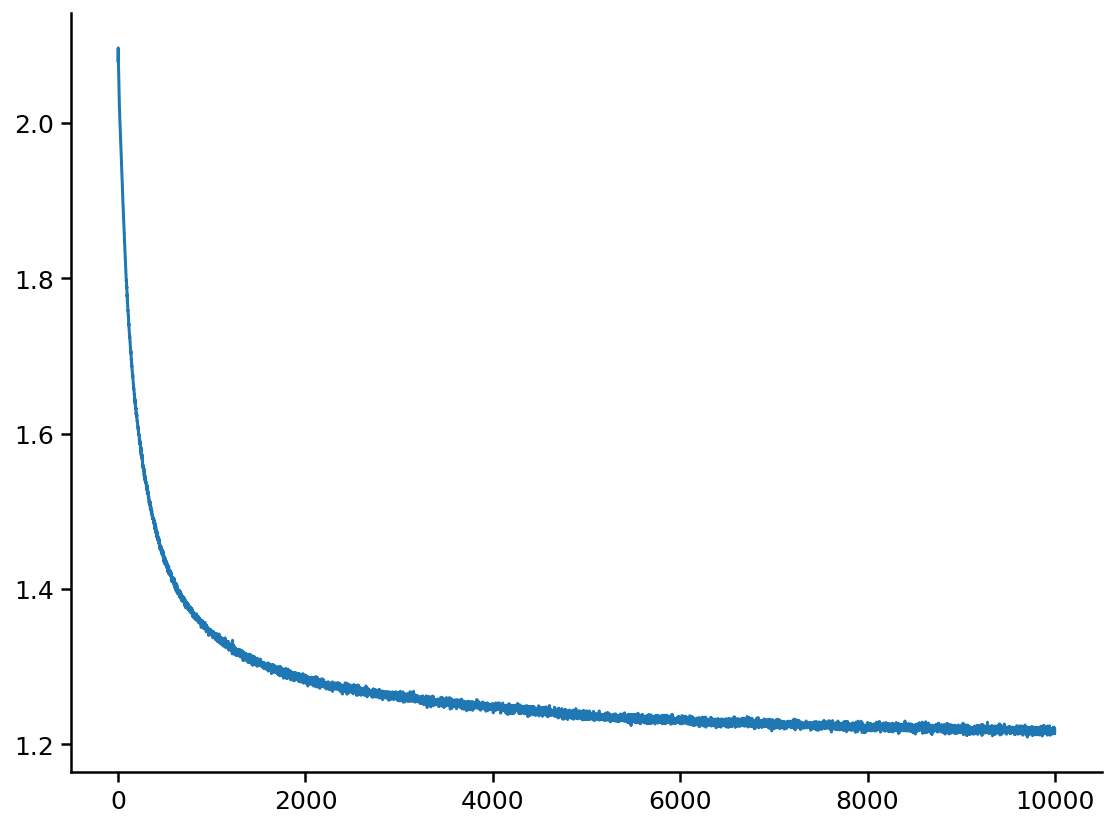

In [51]:
net.train()

for i in tqdm(range(N_epochs)):

  optimizer.zero_grad()
  outputs = net(train_input)
  loss = criterion(outputs,labels)
  loss.backward()
  optimizer.step()

  

  training_losses += [loss.item()]

net.eval()

plt.plot(training_losses)

[[588 119  52  83  53  58  80  61]
 [ 93 612  49 102  53  62  57 107]
 [ 60 107 546 130  39  70  68  87]
 [ 58 100  67 651  59  65  65  81]
 [ 85 148  38 112 503  67  71  91]
 [ 52  96  52 121  55 504  48  89]
 [ 76 107  64 117  46  60 560  75]
 [ 61 108  61  98  66  54  50 566]]
0.5157690993965616
0.7994332055515492


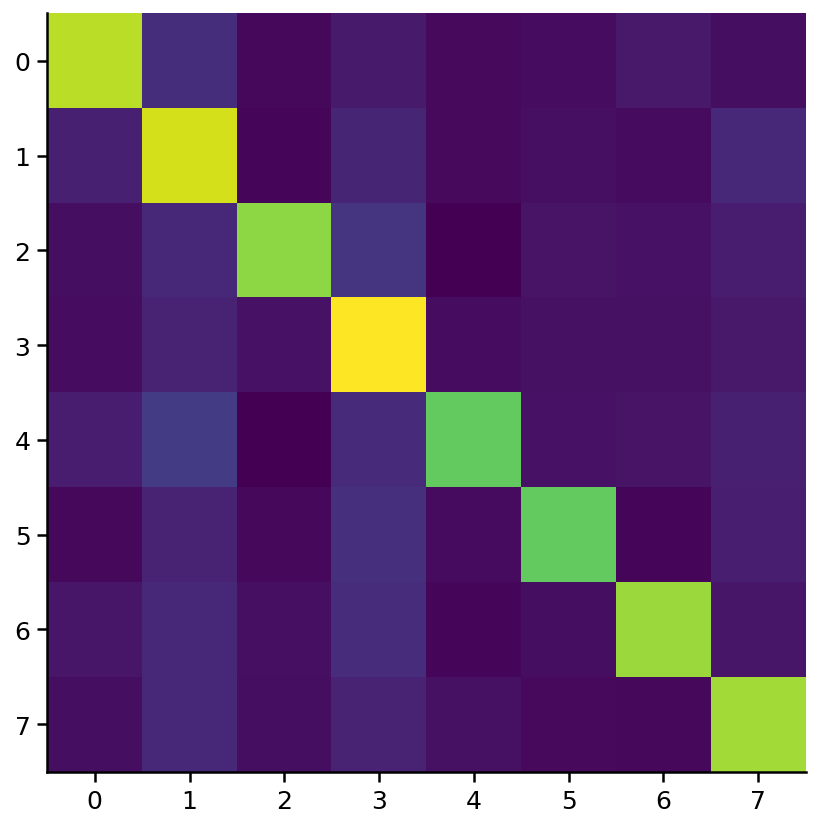

In [52]:
# testing full time course

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#testing
outputs = net(test_input).to('cpu')
_, predictedlabels = torch.max(outputs, 1)
_, truelabels = torch.max(torch.tensor(test_labels),1)

outputs_train = net(train_input).to('cpu')
_, predictedlabels_train = torch.max(outputs_train, 1)
_, truelabels_train = torch.max(torch.tensor(train_labels),1)


correct = ((predictedlabels == truelabels).sum().item())/len(truelabels)
correct_train = ((predictedlabels_train == truelabels_train).sum().item())/len(truelabels_train)

confmat = confusion_matrix(truelabels, predictedlabels)


plt.imshow(confmat)
print(confmat)
print(correct)
print(correct_train)
# fig,axes = plt.subplots(1,6,figsize=(20,5))
# for i in range(0,6):
#   #confmat1 = confusion_matrix(predictedlabels[np.where(test_input[:,122+i].to('cpu'))],truelabels[np.where(test_input_mouse[:,122+i].to('cpu'))])
#   ConfusionMatrixDisplay.from_predictions(truelabels[np.where(test_input[:,122+i].to('cpu'))],predictedlabels[np.where(test_input_mouse[:,122+i].to('cpu'))],ax=axes[i],normalize='true')

# fig,axes = plt.subplots(1,6,figsize=(20,5))
# for i in range(0,6):
#   #confmat1 = confusion_matrix(predictedlabels[np.where(test_input_mouse[:,122+i].to('cpu'))],truelabels[np.where(test_input_mouse[:,122+i].to('cpu'))])
#   ConfusionMatrixDisplay.from_predictions(truelabels_train[np.where(train_input_mouse[:,122+i].to('cpu'))],predictedlabels_train[np.where(train_input_mouse[:,122+i].to('cpu'))],ax=axes[i])


[[487  69  40 100 127  76 152  53]
 [166 309  39  68 127  55 153 217]
 [149  74 404 111 115  92  87  94]
 [112  94  57 425  93  92 161  93]
 [196  91  29 109 427  74  82 120]
 [188  71  71 128 149 255  74  69]
 [192  95  27 108 122  59 377  88]
 [100 137  51  76 177  56 117 377]]
0.3485141751110099
0.5305980440530864


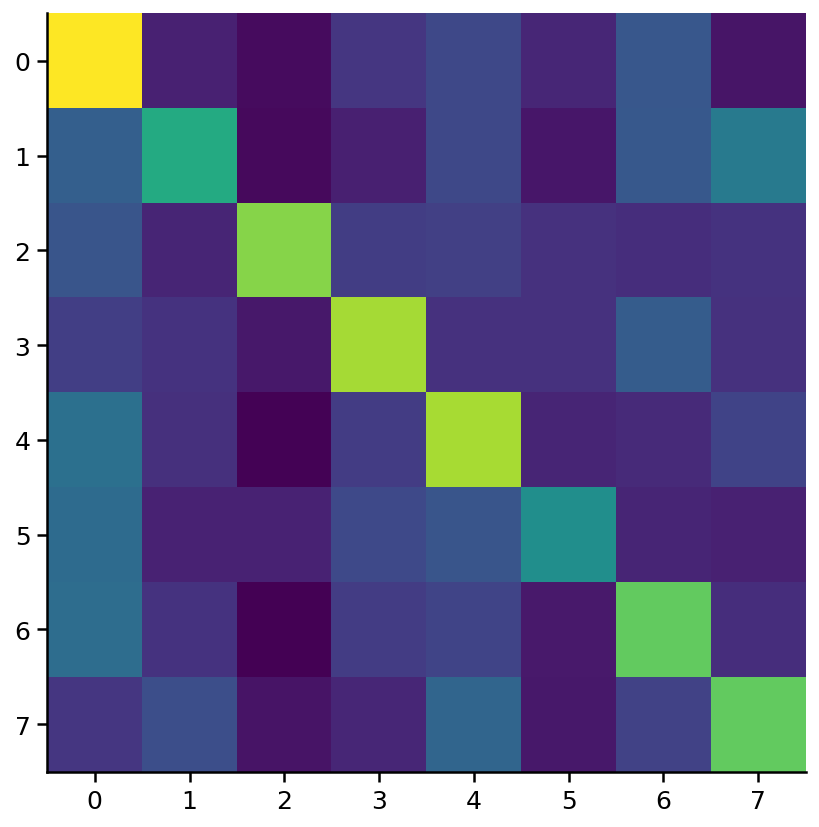

In [17]:
# testing full time course

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#testing
outputs = net(test_input).to('cpu')
_, predictedlabels = torch.max(outputs, 1)
_, truelabels = torch.max(torch.tensor(test_labels),1)

outputs_train = net(train_input).to('cpu')
_, predictedlabels_train = torch.max(outputs_train, 1)
_, truelabels_train = torch.max(torch.tensor(train_labels),1)


correct = ((predictedlabels == truelabels).sum().item())/len(truelabels)
correct_train = ((predictedlabels_train == truelabels_train).sum().item())/len(truelabels_train)

confmat = confusion_matrix(truelabels, predictedlabels)


plt.imshow(confmat)
print(confmat)
print(correct)
print(correct_train)
# fig,axes = plt.subplots(1,6,figsize=(20,5))
# for i in range(0,6):
#   #confmat1 = confusion_matrix(predictedlabels[np.where(test_input[:,122+i].to('cpu'))],truelabels[np.where(test_input_mouse[:,122+i].to('cpu'))])
#   ConfusionMatrixDisplay.from_predictions(truelabels[np.where(test_input[:,122+i].to('cpu'))],predictedlabels[np.where(test_input_mouse[:,122+i].to('cpu'))],ax=axes[i],normalize='true')

# fig,axes = plt.subplots(1,6,figsize=(20,5))
# for i in range(0,6):
#   #confmat1 = confusion_matrix(predictedlabels[np.where(test_input_mouse[:,122+i].to('cpu'))],truelabels[np.where(test_input_mouse[:,122+i].to('cpu'))])
#   ConfusionMatrixDisplay.from_predictions(truelabels_train[np.where(train_input_mouse[:,122+i].to('cpu'))],predictedlabels_train[np.where(train_input_mouse[:,122+i].to('cpu'))],ax=axes[i])


  0%|          | 0/4500 [00:00<?, ?it/s]

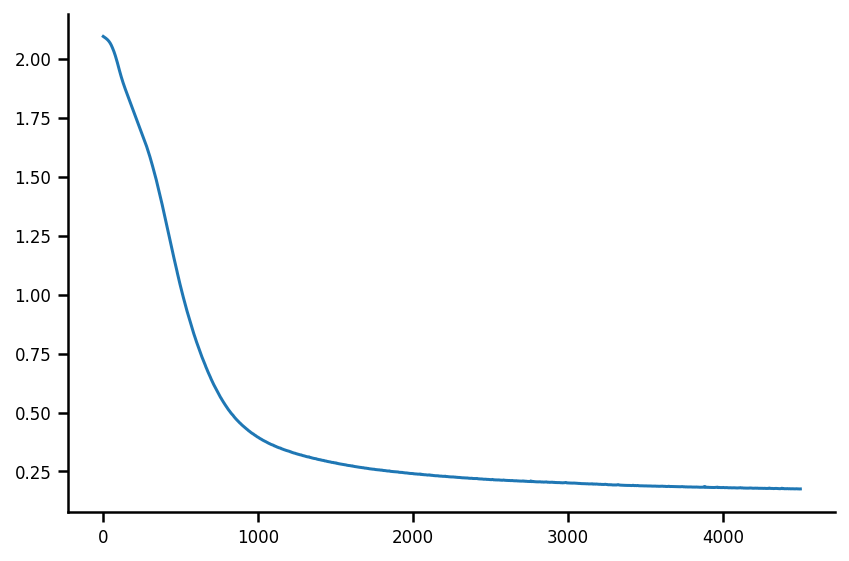

In [ ]:
#NET with mouse ID
net = Net(actv='LeakyReLU(0.1)', input_feature_num=128, hidden_unit_nums=[100, 10, 8], output_feature_num=8).to(DEVICE)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
device = 'cuda'

train_input_mouse = np.hstack((train_input, train_mouse_index))
train_input_mouse = torch.Tensor(train_input_mouse).to(device)

labels = torch.Tensor(train_labels).to(device)

test_input_mouse = np.hstack((test_input, test_mouse_index))
test_input_mouse = torch.Tensor(test_input_mouse).to(device)


training_losses = []
N_epochs = 4500

# Train it
net.to(device)
net.train()

for i in tqdm(range(N_epochs)):

  optimizer.zero_grad()

  #randomly shuffle cell
  #train_input_sh = train_input_mouse[:,np.hstack((np.random.choice(122,122), np.arange(122,128)))]

  outputs = net(train_input_mouse)
  loss = criterion(outputs,labels)
  loss.backward()
  optimizer.step()
  training_losses += [loss.item()]

net.eval()

plt.plot(training_losses)

In [ ]:
#NET with mouse ID and full time course
net = Net(actv='LeakyReLU(0.1)', input_feature_num=[128, 85], hidden_unit_nums=[100, 10, 8], output_feature_num=8).to(DEVICE)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
device = 'cuda'

train_input_mouse = np.hstack((train_input, train_mouse_index))
train_input_mouse = torch.Tensor(train_input_mouse).to(device)

labels = torch.Tensor(train_labels).to(device)

test_input_mouse = np.hstack((test_input, test_mouse_index))
test_input_mouse = torch.Tensor(test_input_mouse).to(device)


training_losses = []
N_epochs = 4500

# Train it
net.to(device)
net.train()

for i in tqdm(range(N_epochs)):

  optimizer.zero_grad()

  #randomly shuffle cell
  #train_input_sh = train_input_mouse[:,np.hstack((np.random.choice(122,122), np.arange(122,128)))]

  outputs = net(train_input_mouse)
  loss = criterion(outputs,labels)
  loss.backward()
  optimizer.step()
  training_losses += [loss.item()]

net.eval()

plt.plot(training_losses)

In [ ]:
np.hstack((np.random.choice(122,122), np.arange(122,128)))

array([ 41,  48,  28,  93,  45, 121, 119,  31,  90,  84,  34,  79,  30,
        46,  56,  57,  61,  13,  57,  66,  59, 108, 106,  36, 118,   5,
        34,  67,  28,   5,  51,  88,  81,  22,   6,  62,   1,  78,  56,
        20,  12,  47,  34,  79,  75,  54,  95,  91, 114,  98,  48, 103,
        62,  79,  88,  39,  39, 103,  29,  48,  36,  67,   5, 107,  32,
        48,  55,   5,  63,  17,   9,  57,  17,  79,  58,  21,  14,  47,
        11,  90,  87, 119,   9,  47,   2,   1,  11, 111,  15,  22,  87,
        73,  65, 110,  37,  25,  32,   4,  16,  80, 112,  54,   4,  10,
        94, 100,  59,  57,  41,  81, 111,  33, 100,  74,   6, 113,  11,
        57, 102,  90,   1,  85, 122, 123, 124, 125, 126, 127])

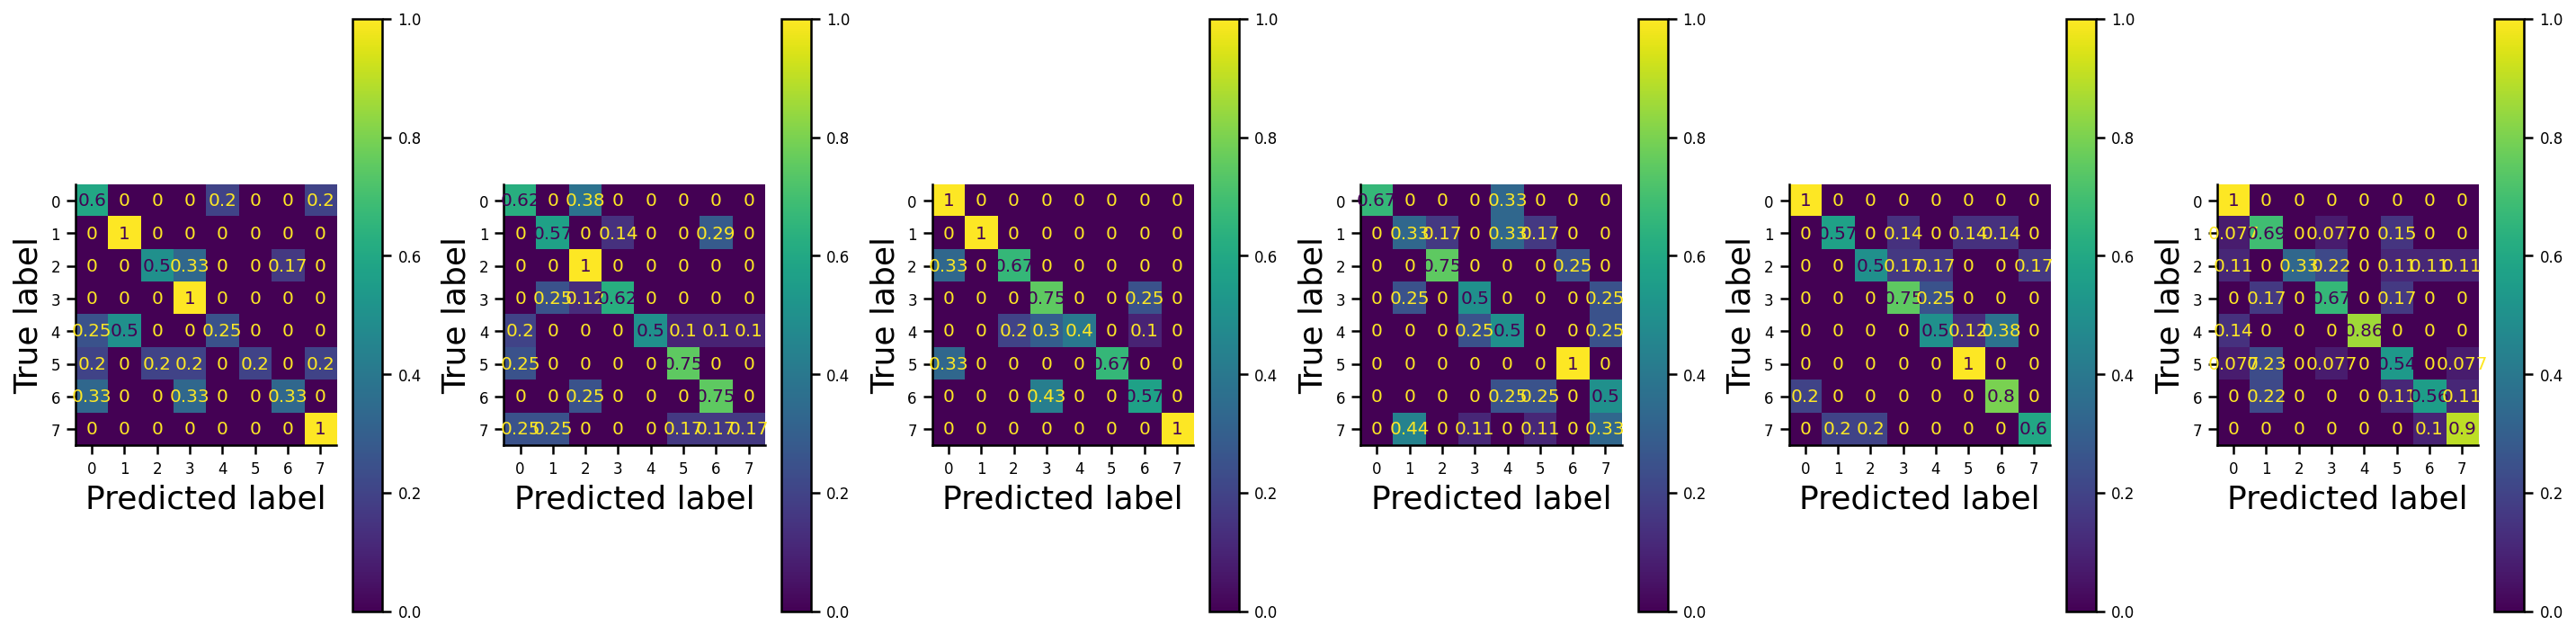

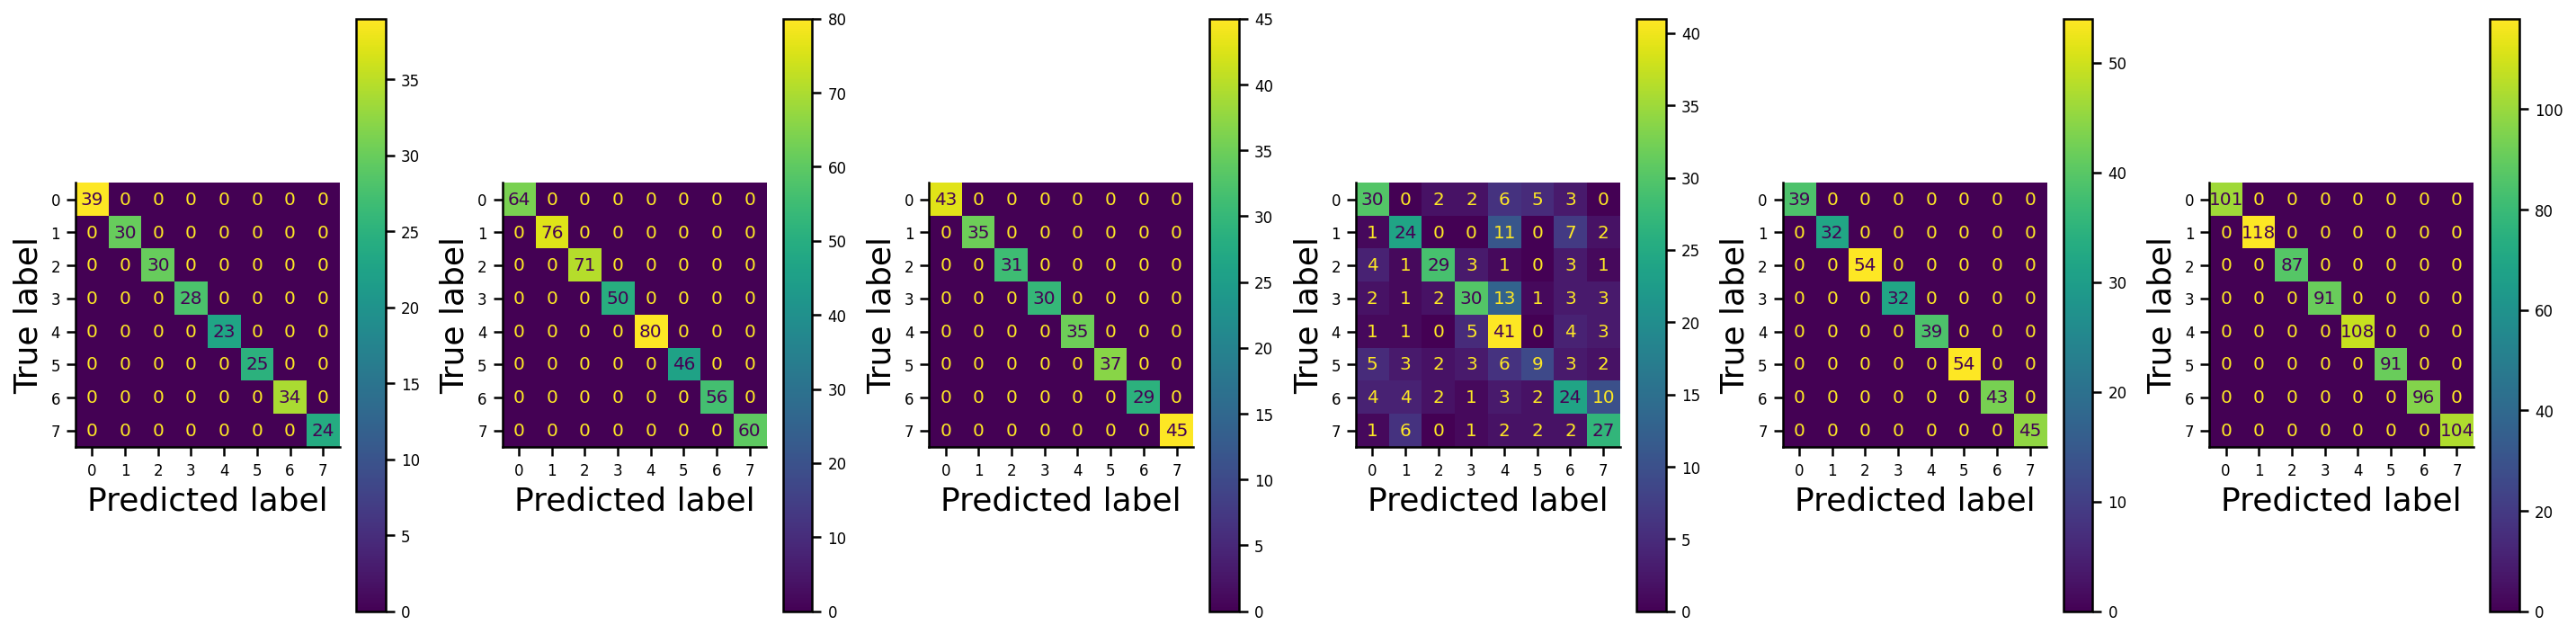

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#testing
outputs = net(test_input_mouse).to('cpu')
_, predictedlabels = torch.max(outputs, 1)
_, truelabels = torch.max(torch.tensor(test_labels),1)

outputs_train = net(train_input_mouse).to('cpu')
_, predictedlabels_train = torch.max(outputs_train, 1)
_, truelabels_train = torch.max(torch.tensor(train_labels),1)


correct = ((predictedlabels == truelabels).sum().item())/len(truelabels)

confmat = confusion_matrix(truelabels, predictedlabels)

#plt.imshow(confmat)
#print(confmat)
#print(correct)

fig,axes = plt.subplots(1,6,figsize=(20,5))
for i in range(0,6):
  confmat1 = confusion_matrix(predictedlabels[np.where(test_input_mouse[:,122+i].to('cpu'))],truelabels[np.where(test_input_mouse[:,122+i].to('cpu'))])
  ConfusionMatrixDisplay.from_predictions(truelabels[np.where(test_input_mouse[:,122+i].to('cpu'))],predictedlabels[np.where(test_input_mouse[:,122+i].to('cpu'))],ax=axes[i],normalize='true')

fig,axes = plt.subplots(1,6,figsize=(20,5))
for i in range(0,6):
  #confmat1 = confusion_matrix(predictedlabels[np.where(test_input_mouse[:,122+i].to('cpu'))],truelabels[np.where(test_input_mouse[:,122+i].to('cpu'))])
  ConfusionMatrixDisplay.from_predictions(truelabels_train[np.where(train_input_mouse[:,122+i].to('cpu'))],predictedlabels_train[np.where(train_input_mouse[:,122+i].to('cpu'))],ax=axes[i])





[[14  0  1  3  0  0  4  2]
 [ 2 24  1  1  0  0  4  2]
 [ 1  2 18  0  0  0  3  2]
 [ 1  1  1 27  1  2  5  1]
 [ 1  2  2  1 24  0  1  2]
 [ 1  5  1  3  2 30  2  4]
 [ 3  3  2  3  0  1 29  1]
 [ 1  0  3  3  1  3  4 20]]
0.6619217081850534


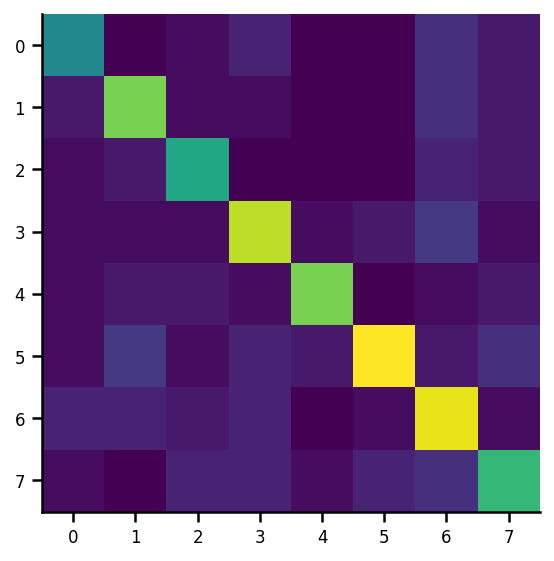

In [31]:
# testing full time course

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#testing
outputs = net(test_input).to('cpu')
_, predictedlabels = torch.max(outputs, 1)
_, truelabels = torch.max(torch.tensor(test_labels),1)

outputs_train = net(train_input).to('cpu')
_, predictedlabels_train = torch.max(outputs_train, 1)
_, truelabels_train = torch.max(torch.tensor(train_labels),1)


correct = ((predictedlabels == truelabels).sum().item())/len(truelabels)

confmat = confusion_matrix(truelabels, predictedlabels)

plt.imshow(confmat)
print(confmat)
print(correct)

# fig,axes = plt.subplots(1,6,figsize=(20,5))
# for i in range(0,6):
#   #confmat1 = confusion_matrix(predictedlabels[np.where(test_input[:,122+i].to('cpu'))],truelabels[np.where(test_input_mouse[:,122+i].to('cpu'))])
#   ConfusionMatrixDisplay.from_predictions(truelabels[np.where(test_input[:,122+i].to('cpu'))],predictedlabels[np.where(test_input_mouse[:,122+i].to('cpu'))],ax=axes[i],normalize='true')

# fig,axes = plt.subplots(1,6,figsize=(20,5))
# for i in range(0,6):
#   #confmat1 = confusion_matrix(predictedlabels[np.where(test_input_mouse[:,122+i].to('cpu'))],truelabels[np.where(test_input_mouse[:,122+i].to('cpu'))])
#   ConfusionMatrixDisplay.from_predictions(truelabels_train[np.where(train_input_mouse[:,122+i].to('cpu'))],predictedlabels_train[np.where(train_input_mouse[:,122+i].to('cpu'))],ax=axes[i])





In [ ]:
torch.sum(train_input_mouse!=0,axis=1).max()-1

tensor(40, device='cuda:0')

In [ ]:
def net_svd(model, in_dim):
  """
  Performs a Singular Value Decomposition on a given model weights
  Args:
    model: torch.nn.Module
      Neural network model
    in_dim: int
      The input dimension of the model
  Returns:
    U: torch.tensor
      Orthogonal matrix
    Σ: torch.tensor
      Diagonal matrix
    V: torch.tensor
      Orthogonal matrix
  """
  W_tot = torch.eye(in_dim)
  for weight in model.parameters():
    W_tot = weight @ W_tot
  U, Σ, V = torch.svd(W_tot)
  return U, Σ, V

[3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5]


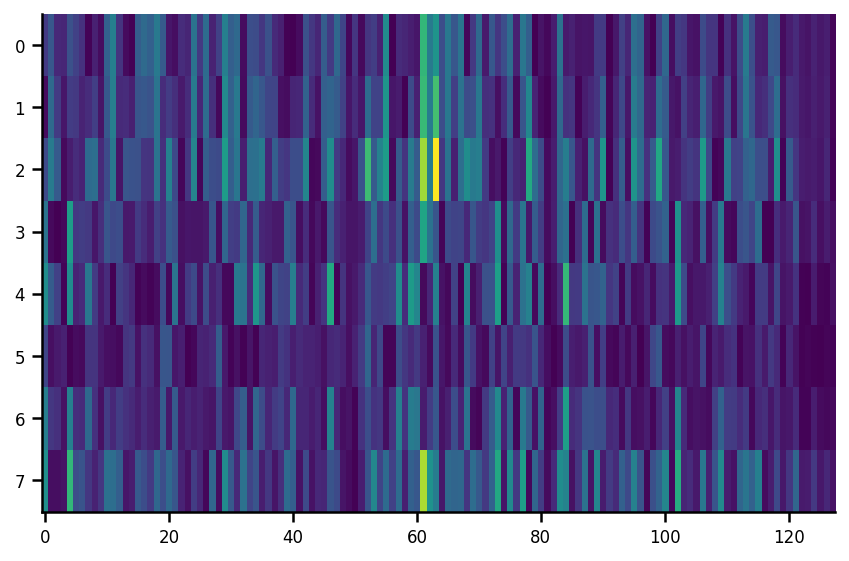

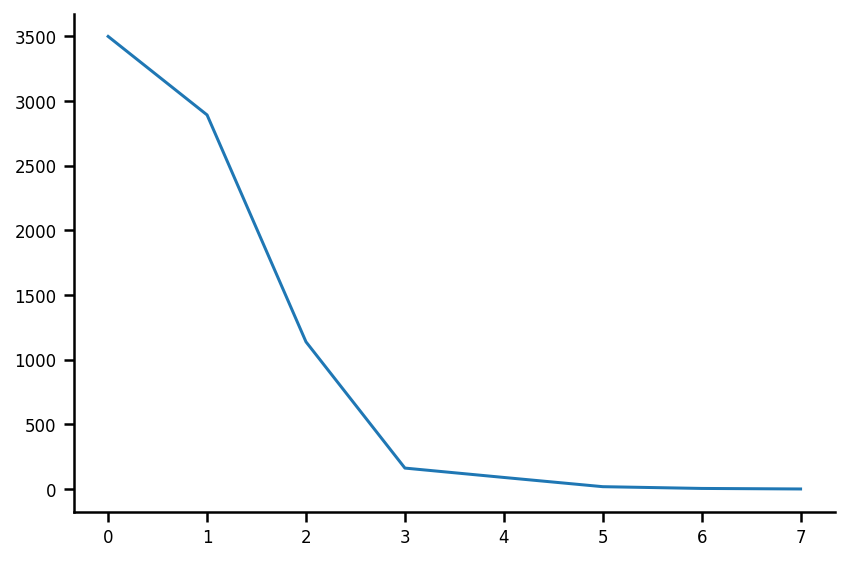

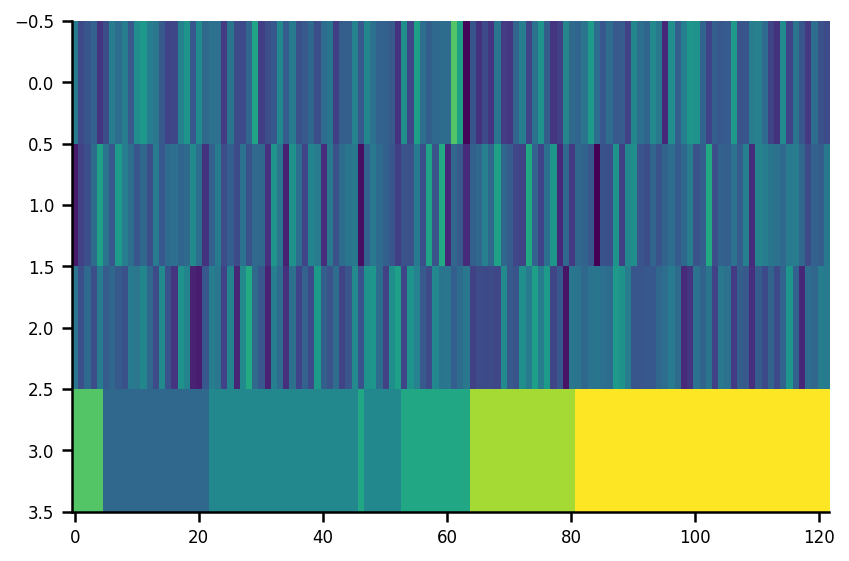

In [ ]:



weights = net.mlp[6].weight@net.mlp[4].weight@net.mlp[2].weight@net.mlp[0].weight
#weights = net.mlp[0].weight

weights = weights.to('cpu').detach().numpy()

print(cell_mouse)
weights_plus_mouse = np.vstack((weights[:,:122], cell_mouse,cell_mouse,cell_mouse))

plt.imshow(np.abs(weights),aspect='auto')

U, Sig, V = torch.svd(torch.tensor(weights))

plt.figure()
plt.plot(Sig)


Vweights_plus_mouse = np.vstack((V[:122,:3].T, cell_mouse/10))
plt.figure()
fig2 = plt.imshow(Vweights_plus_mouse,aspect='auto')
#U, Sigma, V = net_svd(net.to('cpu'), train_input_mouse.size()[1])


In [ ]:
def train_test_classification(net, criterion, optimizer, train_loader,
                              test_loader, num_epochs=1, verbose=True,
                              training_plot=False, device='cpu'):
  """
  Accumulate training loss/Evaluate performance

  Args:
    net: instance of Net class
      Describes the model with ReLU activation, batch size 128
    criterion: torch.nn type
      Criterion combines LogSoftmax and NLLLoss in one single class.
    optimizer: torch.optim type
      Implements Adam algorithm.
    train_loader: torch.utils.data type
      Combines the train dataset and sampler, and provides an iterable over the given dataset.
    test_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.
    num_epochs: int
      Number of epochs [default: 1]
    verbose: boolean
      If True, print statistics
    training_plot=False
      If True, display training plot
    device: string
      CUDA/GPU if available, CPU otherwise

  Returns:
    Nothing
  """
  net.train()
  training_losses = []
  for epoch in tqdm(range(num_epochs)):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      # Get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).long()

      # Zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # Print statistics
      if verbose:
        training_losses += [loss.item()]

  net.eval()

  def test(data_loader):
    """
    Function to gauge network performance

    Args:
      data_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.

    Returns:
      acc: float
        Performance of the network
      total: int
        Number of datapoints in the dataloader
    """
    correct = 0
    total = 0
    for data in data_loader:
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).long()

      outputs = net(inputs)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return total, acc

  train_total, train_acc = test(train_loader)
  test_total, test_acc = test(test_loader)

  if verbose:
    print(f"Accuracy on the {train_total} training samples: {train_acc:0.2f}")
    print(f"Accuracy on the {test_total} testing samples: {test_acc:0.2f}")

  if training_plot:
    plt.plot(training_losses)
    plt.xlabel('Batch')
    plt.ylabel('Training loss')
    plt.show()

  return train_acc, test_acc

10322